Part-1: Key Facial Points Detection

Create the a deep learning model based on CNN and residual blocks to detect key point.

the dataset consists of z and y coordinates of 15 facial key points.

Images are gray scale 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


In [3]:
%cd /content/drive/My Drive/Modern_AI/

/content/drive/My Drive/Modern_AI


In [4]:
# Import the necessary packages

import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from google.colab.patches import cv2_imshow

In [5]:
# Load the dataset
keyfacial_df = pd.read_csv('data.csv')
keyfacial_df.head(5)

left_eye_center_x  ...                                              Image
0          66.033564  ...  238 236 237 238 240 240 239 241 241 243 240 23...
1          64.332936  ...  219 215 204 196 204 211 212 200 180 168 178 19...
2          65.057053  ...  144 142 159 180 188 188 184 180 167 132 84 59 ...
3          65.225739  ...  193 192 193 194 194 194 193 192 168 111 50 12 ...
4          66.725301  ...  147 148 160 196 215 214 216 217 219 220 206 18...

[5 rows x 31 columns]

In [6]:
keyfacial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [7]:
# Check if null values exist in the dataframe
keyfacial_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [8]:
keyfacial_df['Image'].shape

(2140,)

In [9]:
# Since values for the image are given as space separated string, separate the values using ' ' as separator.
# Then convert this into numpy array using np.fromstring and convert the obtained 1D array into 2D array of shape (96, 96)
keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(96, 96))

In [10]:
# Obtain the Shape of the image
keyfacial_df['Image'][0].shape

(96, 96)

In [11]:
keyfacial_df['right_eye_center_x'].describe()

count    2140.000000
mean       29.640269
std         2.051575
min        18.922611
25%        28.472224
50%        29.655440
75%        30.858673
max        42.495172
Name: right_eye_center_x, dtype: float64

Image Visualization

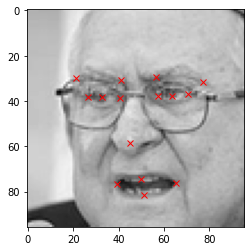

In [12]:
 # plot the random image from the dataset along with facial keypoints.
  
 i = np.random.randint(1, len(keyfacial_df))
 plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')
 for j in range(1, 31, 2):
   plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')

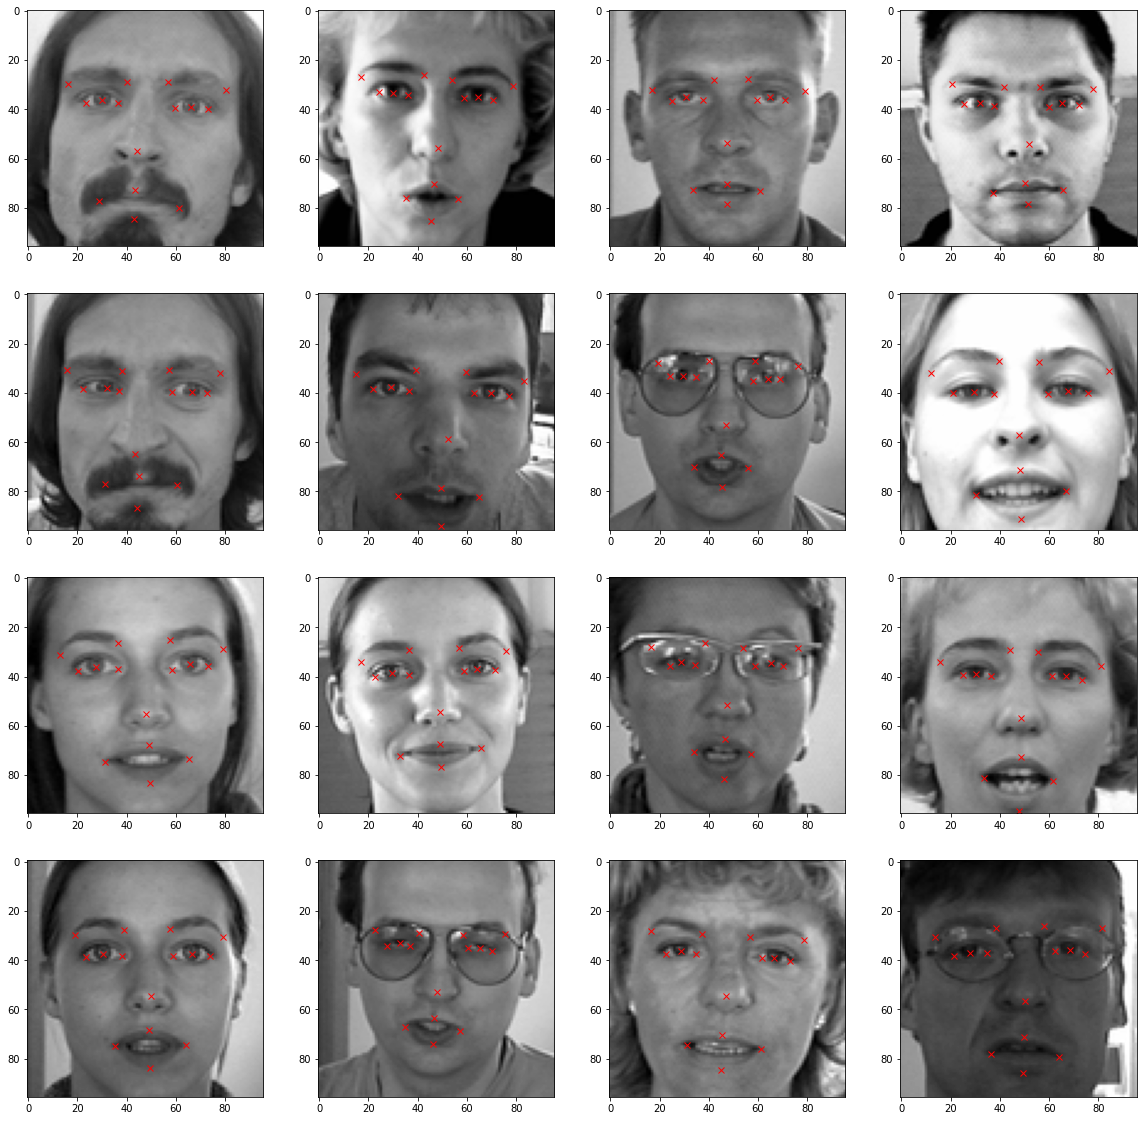

In [13]:
# print the 16 images into the grid

fig = plt.figure(figsize = (20,20))

for i in range(16):
  ax = fig.add_subplot(4, 4, i + 1)
  image = plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')
  for j in range(1,31,2):
    plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')
# Here grid is containing 16 images

Sanity check

Always check the sanity of the data .. 

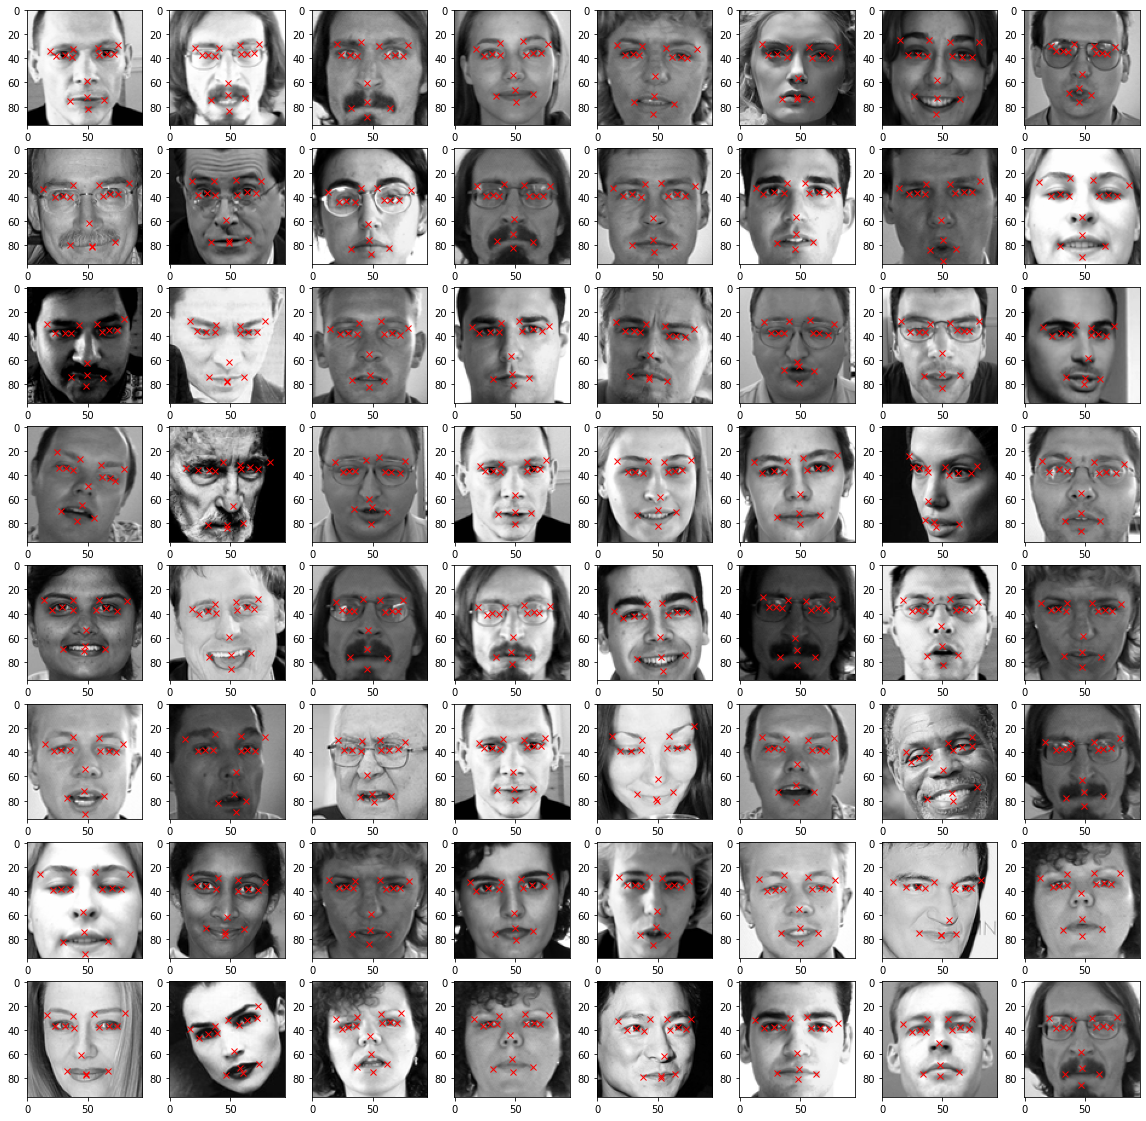

In [14]:
import random
fig = plt.figure(figsize = (20,20))

for i in range(64):
  k = random.randint(1, len(keyfacial_df))
  ax = fig.add_subplot(8, 8, i+1)
  image = plt.imshow(keyfacial_df['Image'][k], cmap = 'gray')
  for j in range(1, 31, 2):
    plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j], 'rx')

Image Augmentation

we want to create the additional data. Take the images and flip vertically, horizontally, change the brightness, zooming and zoomout we can detect key points very nicely.



In [15]:
import copy
keyfacial_df_copy = copy.copy(keyfacial_df)

In [16]:
columns = keyfacial_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [17]:
# Horizontal flip - flipp along y-axis

keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))

for i in range(len(columns)):
  if i % 2 == 0:
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x))



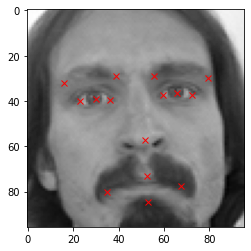

In [18]:
# show the flip images
plt.imshow(keyfacial_df_copy['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [19]:
# create the new dataframe
augment_df = np.concatenate((keyfacial_df, keyfacial_df_copy))
augment_df.shape 

(4280, 31)

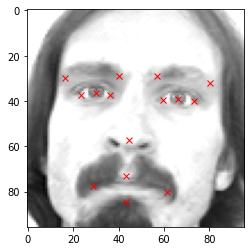

In [20]:
# change the brightness of image
# multiply the image pixel value between 1.5 to 2 and clip the value between 0 to 255

import copy
keyfacial_df_copy1 = copy.copy(keyfacial_df)
keyfacial_df_copy1['Image'] = keyfacial_df_copy1['Image'].apply(lambda x: np.clip(random.uniform(1.5,2) * x, 0.0, 255.0))

# Show the image with more brightness 

plt.imshow(keyfacial_df_copy1['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
  plt.plot(keyfacial_df_copy1.loc[0][j-1], keyfacial_df_copy1.loc[0][j], 'rx')

In [21]:
augment_df = np.concatenate((augment_df, keyfacial_df_copy1))
augment_df.shape 

(6420, 31)

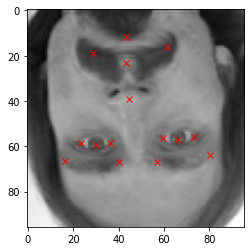

In [22]:
# Vertical flip - flipp along x-axis

keyfacial_df_copy2 = copy.copy(keyfacial_df)
keyfacial_df_copy2['Image'] = keyfacial_df_copy2['Image'].apply(lambda x: np.flip(x, axis = 0))

for i in range(len(columns)):
  if i % 2 == 1:
    keyfacial_df_copy2[columns[i]] = keyfacial_df_copy2[columns[i]].apply(lambda x: 96. - float(x))

# Show the image with more brightness 

plt.imshow(keyfacial_df_copy2['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
  plt.plot(keyfacial_df_copy2.loc[0][j-1], keyfacial_df_copy2.loc[0][j], 'rx')


In [23]:
augment_df = np.concatenate((augment_df, keyfacial_df_copy2))
augment_df.shape 

(8560, 31)

Data Normalization and Data Pre-processing


In [24]:
img = augment_df[:,30]

# normaliz the img
img =img / 255.

# Create an empty array of shape (x, 96, 96, 1) to feed the model
X = np.empty((len(img), 96, 96, 1))

# Iterate through the img list and add image values to the empty array after expanding it's dimension from (96, 96) to (96, 96, 1)
for i in range(len(img)):
  X[i,] = np.expand_dims(img[i], axis = 2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(8560, 96, 96, 1)

In [25]:
# Obtain the value of x & y coordinates which are to used as target.
y = augment_df[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(8560, 30)

In [26]:
# Split the data into train and test data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [27]:
x_train.shape

(6848, 96, 96, 1)

Build the Residual Neural Network to detect the facial key points


In [28]:
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [29]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128,128,512], stage= 3)


# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model_1_facialKeyPoints = Model( inputs= X_input, outputs = X)
model_1_facialKeyPoints.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
_______________________________________________________________________________________

Compile and train the model

In [30]:
adam = tf.keras.optimizers.Adam(lr= 0.0001, beta_1 = 0.9, beta_2 = 0.99, amsgrad= False)
model_1_facialKeyPoints.compile(loss = 'mean_squared_error', optimizer= adam, metrics = ['accuracy'])

In [31]:
# Save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = "FacialKeyPoints_weights.hdf5", verbose = 1, save_best_only = True)

In [32]:
# fit the model
history = model_1_facialKeyPoints.fit(x_train, y_train, batch_size = 32, epochs = 1, callbacks = [checkpointer])

214/214 [==============================] - 4s 18ms/step - loss: 264.5730 - accuracy: 0.5404


In [33]:
# save the model to json file

model_json = model_1_facialKeyPoints.to_json()
with open("FacialKeyPoints-model.json", "w") as json_file:
  json_file.write(model_json)

Assess trained key facial points detection model performance

Weights_keypoint.hdf5 is the pre-trained model, in that model i trained model for more than 100 epochs.


In [34]:
with open('FacialKeyPoints-model.json', 'r') as json_file:
  json_savedModel = json_file.read()

  # load the model architecture
  model_1_facialKeyPoints = tf.keras.models.model_from_json(json_savedModel)
  model_1_facialKeyPoints.load_weights('weights_keypoint.hdf5')
  adam = tf.keras.optimizers.Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.99, amsgrad = False )
  model_1_facialKeyPoints.compile(loss = 'mean_squared_error', optimizer = adam, metrics = ['accuracy'])

In [35]:
# Evaluate the model

result = model_1_facialKeyPoints.evaluate(x_test, y_test)
print("Accuracy: {}".format(result[1]))

54/54 [==============================] - 0s 8ms/step - loss: 193.5005 - accuracy: 0.6910
Accuracy: 0.6910046935081482


In [36]:
# Get the model keys
history.history.keys()

dict_keys(['loss', 'accuracy'])

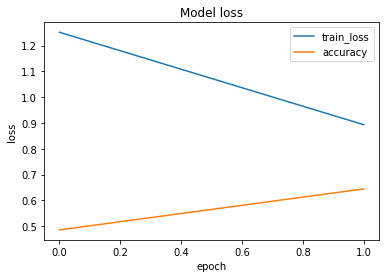

In [125]:
# plot the training artifacts

plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','accuracy'], loc = 'upper right')
plt.show()


Part-2: Facial Expression

Classify the people's emotion

Data belongs to the 5 classes

0 = Angry
1 = Disgust
2 = Sad
3 = Happy
4 = Surprise


In [39]:
# read the csv files for the facial expression data
facialexpression_df = pd.read_csv('icml_face_data.csv')

In [40]:
facialexpression_df

emotion                                             pixels
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1            0  151 150 147 155 148 133 111 140 170 174 182 15...
2            2  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3            2  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4            3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
...        ...                                                ...
24563        3  0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
24564        0  181 177 176 156 178 144 136 132 122 107 131 16...
24565        3  178 174 172 173 181 188 191 194 196 199 200 20...
24566        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
24567        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...

[24568 rows x 2 columns]

In [41]:
facialexpression_df[' pixels'][0] # String format

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [42]:
# function to convert pixel values in string format to array format

def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [43]:
# Resize images from (48, 48) to (96, 96)

def resize(x):
  
  img = x.reshape(48, 48)
  return cv2.resize(img, dsize=(96, 96), interpolation = cv2.INTER_CUBIC)

In [44]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: string2array(x))

In [45]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: resize(x))

In [46]:
facialexpression_df.head()

emotion                                             pixels
0        0  [[69.316925, 73.03865, 79.13719, 84.17186, 85....
1        0  [[151.09435, 150.91393, 150.65791, 148.96367, ...
2        2  [[23.061905, 25.50914, 29.47847, 33.99843, 36....
3        2  [[20.083221, 19.079437, 17.398712, 17.158691, ...
4        3  [[76.26172, 76.54747, 77.001785, 77.7672, 78.4...

In [47]:
# check the shape of data_frame
facialexpression_df.shape

(24568, 2)

In [48]:
# check for the presence of null values in the data frame
facialexpression_df.isnull().sum()

emotion    0
 pixels    0
dtype: int64

In [49]:
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'happiness', 4: 'surprise'}

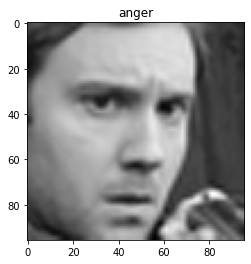

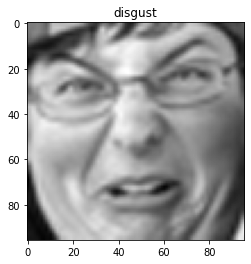

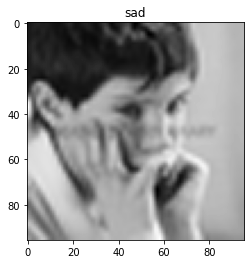

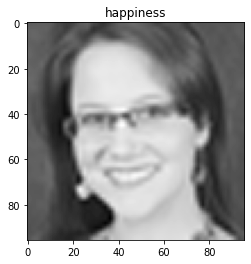

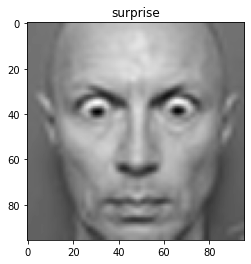

In [50]:
emotions = [0, 1, 2, 3, 4]

for i in emotions:
  data = facialexpression_df[facialexpression_df['emotion'] == i][:1]
  img = data[' pixels'].item()
  img = img.reshape(96, 96)
  plt.figure()
  plt.title(label_to_text[i])
  plt.imshow(img, cmap = 'gray')

Plot the bar char to get idea about the number of samples are present per emotion

In [51]:
facialexpression_df.emotion.value_counts()

3    8989
2    6077
0    4953
4    4002
1     547
Name: emotion, dtype: int64

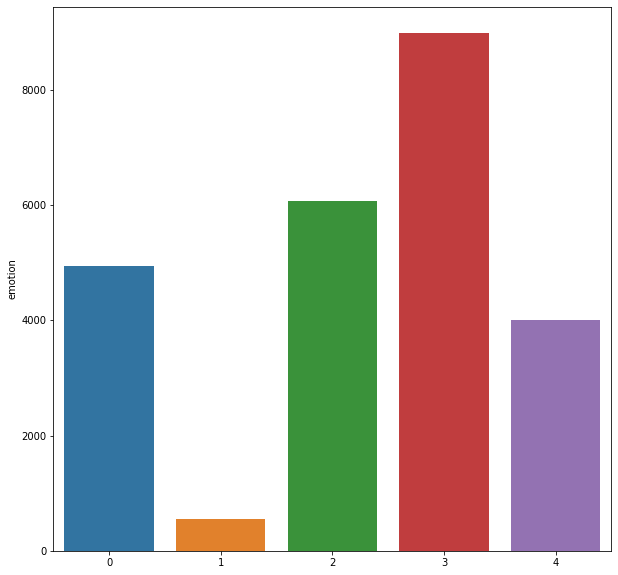

In [52]:
plt.figure(figsize = (10, 10))
sns.barplot(x = facialexpression_df.emotion.value_counts().index,  y = facialexpression_df.emotion.value_counts() )

Image Augmentation


In [53]:
# split the dataframe in to features and labels
from keras.utils import to_categorical

X = facialexpression_df[' pixels']
y = to_categorical(facialexpression_df['emotion'])


In [54]:
X[0]

array([[ 69.316925,  73.03865 ,  79.13719 , ...,  40.73619 ,  40.6584  ,
         40.5394  ],
       [ 68.66325 ,  70.95224 ,  74.71768 , ...,  43.274765,  42.037186,
         41.223618],
       [ 67.768814,  67.71646 ,  67.67172 , ...,  47.39473 ,  44.26329 ,
         42.31465 ],
       ...,
       [ 74.89021 ,  76.79553 ,  79.90259 , ...,  71.463425,  59.32875 ,
         51.74736 ],
       [ 76.68126 ,  75.808105,  74.25452 , ...,  93.943375,  79.77934 ,
         71.13246 ],
       [ 77.63858 ,  75.15074 ,  70.8846  , ..., 107.66351 ,  92.23212 ,
         82.91585 ]], dtype=float32)

In [55]:
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [56]:

X = np.stack(X, axis = 0)
X = X.reshape(24568, 96, 96, 1)

print(X.shape, y.shape)

(24568, 96, 96, 1) (24568, 5)


In [57]:
# split the dataframe in to train, test and validation data frames

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_Test = train_test_split(X, y, test_size = 0.1, shuffle = True)
X_val, X_test, y_val, y_Test = train_test_split(X_test, y_Test, test_size = 0.5, shuffle = True)


In [58]:
print(X_val.shape, y_val.shape)

(1228, 96, 96, 1) (1228, 5)


In [59]:
# image pre-processing

X_train = X_train/255
X_val   = X_val /255
X_test  = X_test/255

In [60]:
# Image Augmentation

train_datagen = ImageDataGenerator(
rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest")

# Note for the Brightness_range:
# brightness_range = 1.0 does not affect image brightness
# brightness_range = [0.5,1.0] darken the image
# brightness_range = [1.0,1.5] brighten the image

Build and Train the Deep Neural Network for Facial xpression Classification

In [61]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)

# 4 - stage
# X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((4, 4), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_2_emotion = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_2_emotion.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [62]:
# train the network
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [63]:
# Recall that the first facial key points model was saved as follows: FacialKeyPoints_weights.hdf5 and FacialKeyPoints-model.json

# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "FacialExpression_weights.hdf5", verbose = 1, save_best_only=True)

In [64]:
history = model_2_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=64),
	validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,
	epochs= 2, callbacks=[checkpointer, earlystopping])

Epoch 1/2
345/345 [==============================] - ETA: 0s - loss: 1.2516 - accuracy: 0.4856
Epoch 00001: val_loss improved from inf to 1.44694, saving model to FacialExpression_weights.hdf5
345/345 [==============================] - 22s 64ms/step - loss: 1.2516 - accuracy: 0.4856 - val_loss: 1.4469 - val_accuracy: 0.3249
Epoch 2/2
345/345 [==============================] - ETA: 0s - loss: 0.8932 - accuracy: 0.6446
Epoch 00002: val_loss improved from 1.44694 to 1.09778, saving model to FacialExpression_weights.hdf5
345/345 [==============================] - 21s 61ms/step - loss: 0.8932 - accuracy: 0.6446 - val_loss: 1.0978 - val_accuracy: 0.5423


In [65]:
# saving the model architecture to json file for future use

model_json = model_2_emotion.to_json()
with open("FacialExpression-model.json","w") as json_file:
  json_file.write(model_json)

Assess the performance of trained facial expression classifier model

In [66]:
with open('FacialExpression-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model_2_emotion = tf.keras.models.model_from_json(json_savedModel)
model_2_emotion.load_weights('weights_emotions.hdf5')
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [68]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [70]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['loss']

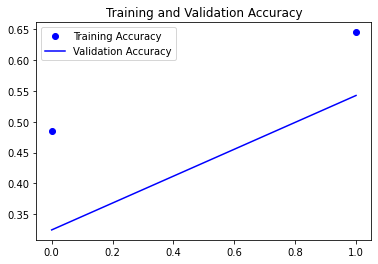

In [71]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend( )

In [72]:
# predicted_classes = model.predict_classes(X_test)
predicted_classes = np.argmax(model_2_emotion.predict(X_test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)

In [73]:
predicted_classes.shape

(1229,)

In [74]:
y_true.shape

(1229,)

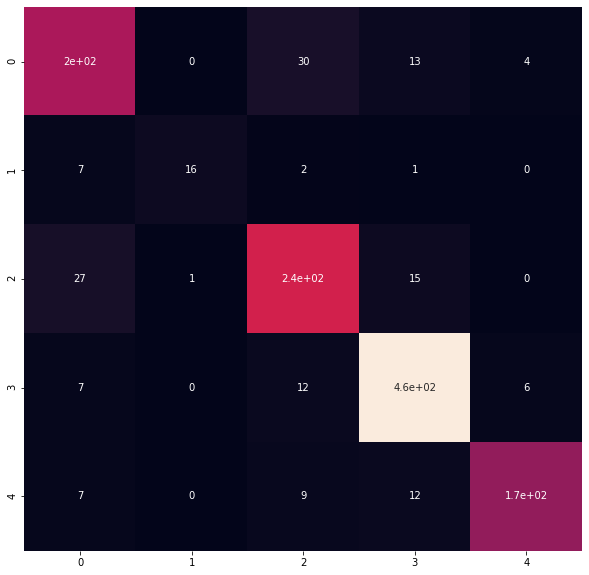

In [75]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10,10))
sns.heatmap(cm, annot=True, cbar = False) # cbar for color bar 

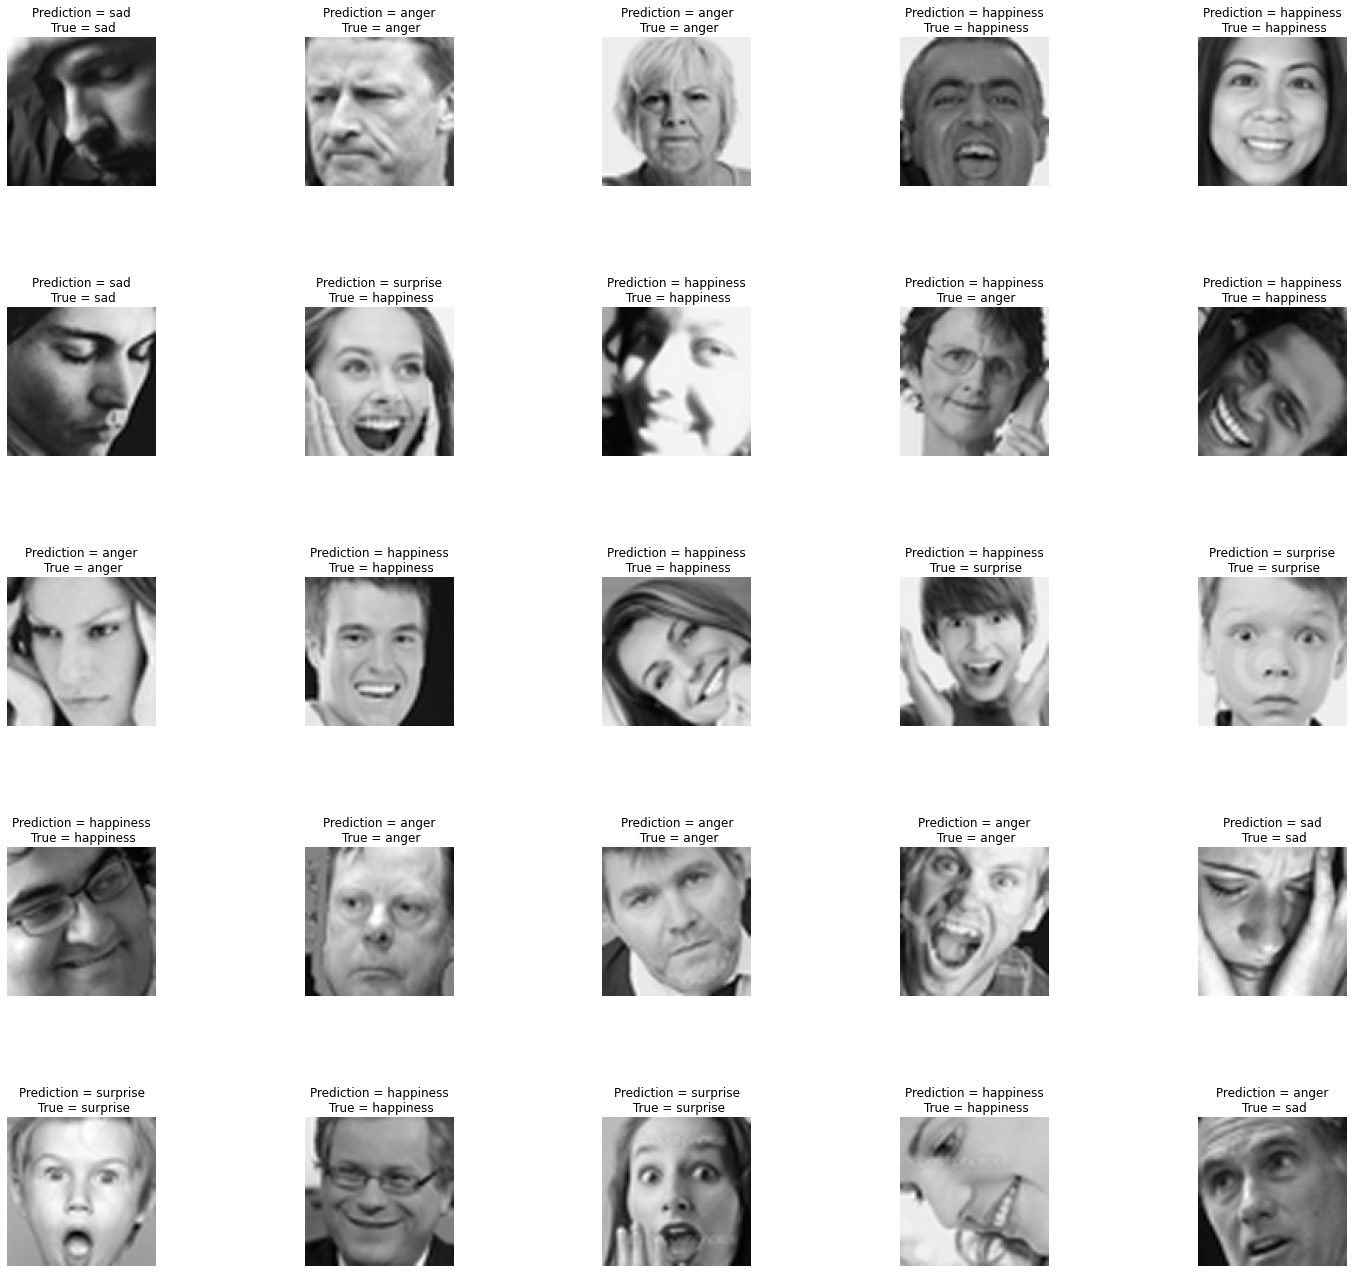

In [76]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_test[i].reshape(96,96), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)   

In [77]:
# Classification report and recall

from sklearn.metrics import classification_report
report = classification_report(y_true, predicted_classes)
report

'              precision    recall  f1-score   support\n\n           0       0.80      0.81      0.80       242\n           1       0.94      0.62      0.74        26\n           2       0.82      0.85      0.83       282\n           3       0.92      0.95      0.93       484\n           4       0.94      0.86      0.90       195\n\n    accuracy                           0.88      1229\n   macro avg       0.88      0.81      0.84      1229\nweighted avg       0.88      0.88      0.88      1229\n'

Part-3 Combine the Both facial expression model and facial key points detection




In [107]:
def predict(X_test):

  # Making prediction from the keypoint model
  df_predict = model_1_facialKeyPoints.predict(X_test)

  # Making prediction from the emotion model
  df_emotion = np.argmax(model_2_emotion.predict(X_test), axis=-1)

  # Reshaping array from (856,) to (856,1)
  df_emotion = np.expand_dims(df_emotion, axis = 1)

  # Converting the predictions into a dataframe
  df_predict = pd.DataFrame(df_predict, columns= columns)

  # Adding emotion into the predicted dataframe
  df_predict['emotion'] = df_emotion

  return df_predict

In [108]:
df_predict = predict(X_test)

In [109]:
df_predict.head()

left_eye_center_x  left_eye_center_y  ...  mouth_center_bottom_lip_y  emotion
0          61.802513          33.050900  ...                  79.731415        2
1          63.706825          37.051029  ...                  77.914040        0
2          49.152973          41.344017  ...                  81.516266        0
3          29.206451          38.409378  ...                  85.650887        3
4          30.665760          30.479130  ...                  78.330368        3

[5 rows x 31 columns]

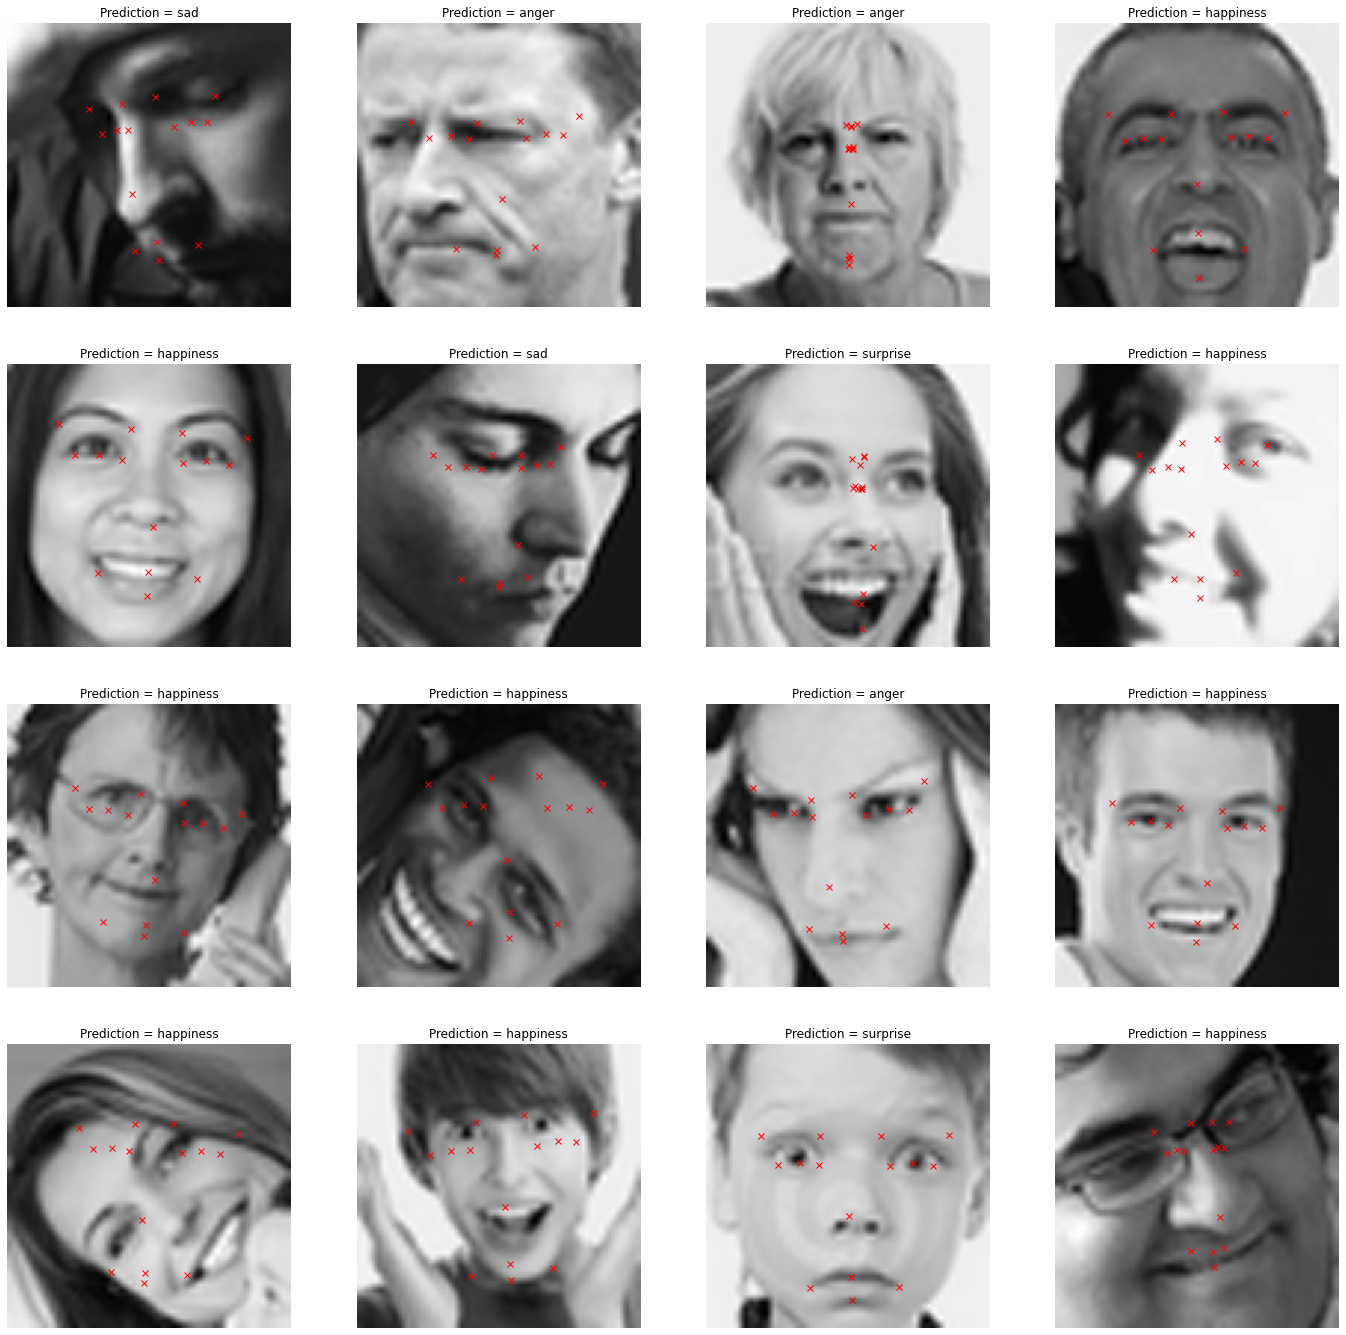

In [110]:
fig, axes = plt.subplots(4, 4, figsize = (24, 24))
axes = axes.ravel()

for i in range(16):

    axes[i].imshow(X_test[i].squeeze(),cmap='gray')
    axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))
    axes[i].axis('off')
    for j in range(1,31,2):
            axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')

Save the Trained Model for Deployment

Integrate our trained Tensorflow model into a web app and deploy the model in production level enviornment.

--> Tensorflow Serving: High performance serving system for machine learning models, designed for production enviornments.

--> Using Tensorflow Serving, we can easily deploy new algorithms to make predictions.

--> We need ti save the model in the format that is suitable for serving using Tensorflow Serving.

--> After the model is saved, we can use Tensorflow Serving to start making inference requests using a specific version of our trained model "servable".


There are some important parameters:
1. rest_api_port: the port that you will be use for the REST request.

2. model_name: You will use this in the URL of REST requests. You can choose any name.

3. model_base_path: This is the path to the directory where you have saved your model.

REST is a revival of HTTP in which http commands have semantic meaning.


Making Request in TensorFlow Serving:

--> In order to making prediction using TensorFlow serving, we need to pass the inference request (image data) as a JSON object.

--> Then, we use Python requests library to make post request to the deployed model, by passing in the JSON object containing inference requests.

--> Finally, we get the prediction from the post request made to the deployed model and then use argmax function to find the prediced class.





In [111]:
import json
import tensorflow.keras.backend as K

def deploy(directory, model):
  MODEL_DIR = directory
  version = 1 

  # Let's join the temp model directory with our chosen version number 
  # The expected result will be = '\tmp\version number'
  export_path = os.path.join(MODEL_DIR, str(version))
  print('export_path = {}\n'.format(export_path))

  # Let's save the model using saved_model.save
  # If the directory already exists, we will remove it using '!rm' 
  # rm removes each file specified on the command line. 

  if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

  tf.saved_model.save(model, export_path)

  os.environ["MODEL_DIR"] = MODEL_DIR

Serve The Model Using TensorFlow Serving

In [112]:
# Let's add tensorflow-model-server package to our list of packages 
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   159k      0 --:--:-- --:--:-- --:--:--  159k
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://archive.ubuntu.com/

In [113]:
# Let's install tensorflow model server
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (2.3.0).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [114]:
deploy('/model', model_1_facialKeyPoints)

export_path = /model/1


Already saved a model, cleaning up

INFO:tensorflow:Assets written to: /model/1/assets


In [115]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=4500 \
  --model_name=keypoint_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 3 in a separate thread.


In [116]:
!tail server.log

2020-12-14 23:51:06.075781: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 33554432 exceeds 10% of free system memory.
2020-12-14 23:51:06.114510: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 33554432 exceeds 10% of free system memory.
2020-12-14 23:51:06.154263: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:183] Running initialization op on SavedModel bundle at path: /model/1
2020-12-14 23:51:06.201795: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:303] SavedModel load for tags { serve }; Status: success: OK. Took 314990 microseconds.
2020-12-14 23:51:06.209558: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /model/1/assets.extra/tf_serving_warmup_requests
2020-12-14 23:51:06.209991: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: keypoint_model version: 1}
2020-12-

In [117]:
deploy('/model1', model_2_emotion)

export_path = /model1/1

INFO:tensorflow:Assets written to: /model1/1/assets


In [118]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=4000 \
  --model_name=emotion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 4 in a separate thread.


In [119]:
!tail server.log

To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-12-14 23:51:39.550543: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:199] Restoring SavedModel bundle.
2020-12-14 23:51:39.687058: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:183] Running initialization op on SavedModel bundle at path: /model1/1
2020-12-14 23:51:39.732227: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:303] SavedModel load for tags { serve }; Status: success: OK. Took 242067 microseconds.
2020-12-14 23:51:39.740378: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /model1/1/assets.extra/tf_serving_warmup_requests
2020-12-14 23:51:39.740697: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: emotion_model version: 1}
2020-12-14 23:51:39.742720: I tensorflow_serving/model_servers/server.cc:367] Running gRPC ModelServer at 0.0.0.0:8500 

Make Request To Model In TensorFlow Serving

In [120]:
import json

# Let's create a JSON object and make 3 inference requests
data = json.dumps({"signature_name": "serving_default", "instances": X_test[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... 085], [0.6822478175163269], [0.6807421445846558]]]]}


In [94]:
!pip install flask

In [95]:
!pip install requests

In [121]:
import requests

# Function to make predictions from deployed models
def response(data):
  headers = {"content-type": "application/json"}
  json_response = requests.post('http://localhost:4500/v1/models/keypoint_model/versions/1:predict', data=data, headers=headers, verify = False)
  df_predict = json.loads(json_response.text)['predictions']
  json_response = requests.post('http://localhost:4000/v1/models/emotion_model/versions/1:predict', data=data, headers=headers, verify = False)
  df_emotion = np.argmax(json.loads(json_response.text)['predictions'], axis = 1)
  
  # Reshaping array from (856,) to (856,1)
  df_emotion = np.expand_dims(df_emotion, axis = 1)

  # Converting the predictions into a dataframe
  df_predict= pd.DataFrame(df_predict, columns = columns)

  # Adding emotion into the predicted dataframe
  df_predict['emotion'] = df_emotion

  return df_predict

In [122]:
# making prediction
df_predict = response(data)

In [123]:
df_predict

left_eye_center_x  left_eye_center_y  ...  mouth_center_bottom_lip_y  emotion
0          61.802498          33.050900  ...                  79.731415        2
1          63.706829          37.051025  ...                  77.914047        0
2          49.152908          41.344013  ...                  81.516251        0

[3 rows x 31 columns]

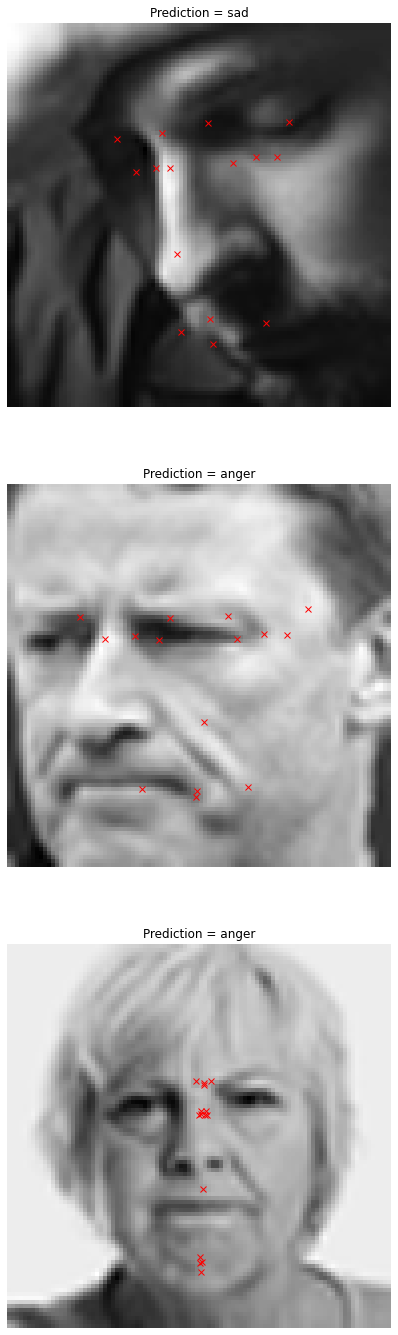

In [124]:
# Plotting the test images and their predicted keypoints and emotions

fig, axes = plt.subplots(3, 1, figsize = (24, 24))
axes = axes.ravel()

for i in range(3):

    axes[i].imshow(X_test[i].squeeze(),cmap='gray')
    axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))
    axes[i].axis('off')
    for j in range(1,31,2):
            axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')
            